In [1]:
import sys
import os

os.chdir("C:/Users/MSI/OneDrive/Dokumen/datmin/LLM/GPT")
print(f"Current working directory: {os.getcwd()}")

# Add src to sys.path
sys.path.append(os.path.abspath("src"))

import torch
import tiktoken
from utils.train import (
    text_to_token_ids,
    token_ids_to_text,
    calc_loss_batch,
    calc_loss_loader,
    evaluate_model,
    generate_and_print_sample,
    train_model_simple_with_timing,
    plot_losses,
    generate
)
import time
from utils.dataloader import create_dataloader_v1
from src.gpt import GPTModel

Current working directory: C:\Users\MSI\OneDrive\Dokumen\datmin\LLM\GPT


In [2]:
file_path = 'data/raw/pride-and-prejudice.txt'

with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-key-value bias
}

OTHER_SETTINGS = {
    "learning_rate": 5e-4,
    "num_epochs": 10,
    "batch_size": 2,
    "weight_decay": 0.1
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data, allowed_special={'<|endoftext|>'}))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 748126
Tokens: 196251


In [5]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [6]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 102

In [7]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 176128
Validation tokens: 18432
All tokens: 194560


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_simple_with_timing(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    device,
    num_epochs=num_epochs, 
    eval_freq=5, 
    eval_iter=5,
    start_context="Every effort moves you", 
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1, Step 000000, Train: 10.333, Val: 10.294, Step tok/sec: 123, Avg tok/sec: 0
Ep 1, Step 000005, Train: 7.834, Val: 8.067, Step tok/sec: 64, Avg tok/sec: 64
Ep 1, Step 000010, Train: 6.842, Val: 6.864, Step tok/sec: 78, Avg tok/sec: 71
Ep 1, Step 000015, Train: 6.218, Val: 6.390, Step tok/sec: 79, Avg tok/sec: 73
Ep 1, Step 000020, Train: 5.736, Val: 6.259, Step tok/sec: 80, Avg tok/sec: 75
Ep 1, Step 000025, Train: 6.077, Val: 6.191, Step tok/sec: 81, Avg tok/sec: 76
Ep 1, Step 000030, Train: 5.473, Val: 6.167, Step tok/sec: 81, Avg tok/sec: 77
Ep 1, Step 000035, Train: 6.084, Val: 6.104, Step tok/sec: 81, Avg tok/sec: 77
Ep 1, Step 000040, Train: 6.013, Val: 6.003, Step tok/sec: 81, Avg tok/sec: 78
Ep 1, Step 000045, Train: 5.868, Val: 6.177, Step tok/sec: 81, Avg tok/sec: 78
Ep 1, Step 000050, Train: 5.803, Val: 6.041, Step tok/sec: 80, Avg tok/sec: 78
Ep 1, Step 000055, Train: 5.968, Val: 5.972, Step tok/sec: 81, Avg tok/sec: 78
Ep 1, Step 000060, Train: 5.494, Val: 5.925, Step 

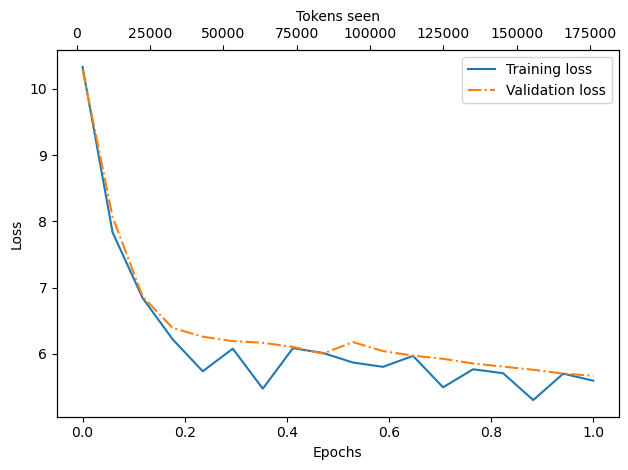

In [10]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [12]:
model.to("cpu") 
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you that of them.
of her, as been
B that a with


save the trained models

In [14]:
torch.save(model.state_dict(), "models/model.pth")

In [15]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "models/model_and_optimizer.pth"
)

In [16]:

checkpoint = torch.load("models/model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();